In [10]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve
from matplotlib import rcParams
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc,roc_auc_score
import umap
from sklearn.inspection import permutation_importance
import os
import sklearn.cluster as cluster
import warnings
warnings.filterwarnings('ignore')
os.chdir('../final_dataset/')

In [11]:
data = pd.read_csv('Morpholoy_data.csv')

In [12]:
data =data[data['Expert_label'].isin(['L-stellate','D-stellate','Cartwheel','Vertical','SSC'])]
data =data[~data['Penk_tdTomato'].isin(['YES'])]
data = data.fillna(0)

In [13]:
labels = ['L-stellate','D-stellate','Cartwheel','Vertical','SSC']
labels  = sorted(labels)

In [14]:
adata = data.copy()
adata = adata[list(adata.columns)[1:45]+['spine','Expert_label']] #select the none-sholl analysis data

In [15]:
X = adata.drop(['Expert_label'], axis=1)
para = list(X.columns)
#x = x.values
X = StandardScaler().fit_transform(X)
y = adata['Expert_label']
print(f'x shape: {X.shape} | y shape: {y.shape} ')

x shape: (116, 45) | y shape: (116,) 


In [16]:
for name in labels:
    print(name, len(y[y == name]))

Cartwheel 15
D-stellate 17
L-stellate 33
SSC 13
Vertical 38


In [17]:
clf = RandomForestClassifier(n_estimators=100,random_state=0,bootstrap =True, n_jobs = 10)

In [18]:
random_state_n = []
n = 0
for i in range(0,10000,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if accuracy_score(y_test, y_pred) > 0.95:
        n  = n + 1
        random_state_n.append(i)
        if n == 100:
            break

In [20]:
cm = 0
train_score = 0
test_score = 0
fpr1 = pd.DataFrame()
tpr1 = pd.DataFrame()
fpr2 = pd.DataFrame()
tpr2 = pd.DataFrame()
fpr3 = pd.DataFrame()
tpr3 = pd.DataFrame()
fpr4 = pd.DataFrame()
tpr4 = pd.DataFrame()
fpr5 = pd.DataFrame()
tpr5 = pd.DataFrame()
importances = pd.DataFrame(index = para,columns = ['importances'])
importances['importances'] = 0.0
k = 0
for i in random_state_n:
    #print(k+1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    matrix = confusion_matrix(y_test, y_pred)
    cm = cm+matrix
    ###Learning Curve
    train_sizes =  np.arange(0.1,1,0.025)
    sizes, training_scores, testing_scores = learning_curve(clf, X_train, y_train,
                                                            scoring='accuracy', train_sizes=train_sizes)
    mean_training = np.mean(training_scores, axis=1)
    train_score = train_score+mean_training
    Standard_Deviation_training = np.std(training_scores, axis=1)
    mean_testing = np.mean(testing_scores, axis=1)
    test_score = test_score + mean_testing
    Standard_Deviation_testing = np.std(testing_scores, axis=1)
    ###Freature importance
    importance = pd.DataFrame(clf.feature_importances_,index = para,columns = ['importances'])
    importances  = importances + importance
    ###ROC curve
    pred_prob = clf.predict_proba(X_test)
    fpr = {}
    tpr = {}
    thresh ={}
    n_class =labels
    for j in range(5):    
        fpr[j], tpr[j], thresh[j] = roc_curve(y_test, pred_prob[:,j], pos_label=n_class[j])
    fpr1[k] = pd.DataFrame(fpr[0])
    tpr1[k] = pd.DataFrame(tpr[0])
    fpr2[k] = pd.DataFrame(fpr[1])
    tpr2[k] = pd.DataFrame(tpr[1])
    fpr3[k] = pd.DataFrame(fpr[2])
    tpr3[k] = pd.DataFrame(tpr[2])
    fpr4[k] = pd.DataFrame(fpr[3])
    tpr4[k] = pd.DataFrame(tpr[3])
    fpr5[k] = pd.DataFrame(fpr[4])
    tpr5[k] = pd.DataFrame(tpr[4])
    k=k+1

In [ ]:
Cartwheel 717 / 719 99.72%
D-stellate 643 / 680 94.56%
L-stellate 1649 / 1724 95.65%
SSC 675 / 681 99.12%
Vertical 1936 / 1996 96.99%
96.90%

In [21]:
true_n = 0
total_n = 0
for i in range(0,5,1):
    print(labels[i],cm[i,i],'/',sum(cm[:,i]), str('%.2f'%(cm[i,i]/sum(cm[:,i])*100.0))+'%')
    true_n = true_n + cm[i,i]
    total_n = total_n + sum(cm[:,i])   
    acur_rate = true_n/total_n*100.0

print(str('%.2f'%(acur_rate))+'%')

Cartwheel 717 / 719 99.72%
D-stellate 643 / 680 94.56%
L-stellate 1649 / 1724 95.65%
SSC 675 / 681 99.12%
Vertical 1936 / 1996 96.99%
96.90%


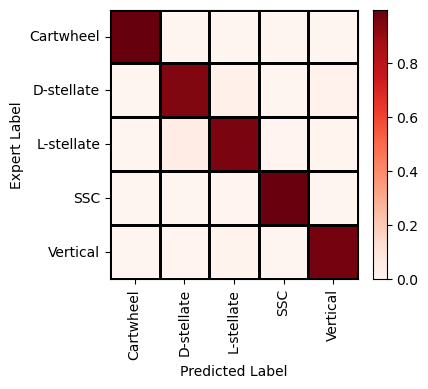

In [22]:
cm = cm.astype(np.float32)
for i in range(0,5,1):
    cm[:,i] = cm[:,i]/sum(cm[:,i])
rcParams['figure.figsize'] = 4, 3.5
ax = sns.heatmap(cm, cmap='Reds',cbar=True,
                 linewidths=1, linecolor='black'#,annot = True, annot_kws = {'size':14},fmt='0.3f'
                )
sns.despine(top = False, right = False, left = False,bottom = False)  
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_yticklabels(ax.get_yticklabels(),rotation = 0)

plt.rc('axes', titlesize=16)     
plt.rc('axes', labelsize=16)
plt.rc('font', size=16) 
plt.rc('figure', titlesize=16)
plt.rc('legend', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('Expert Label')
plt.savefig('InN_M_cluster_ML_Matrix.pdf',dpi = 300)

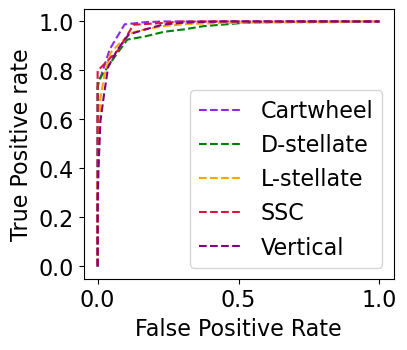

In [23]:
plt.plot(fpr1.mean(axis=1)/max(fpr1.mean(axis=1)), 
         tpr1.mean(axis=1)/max(tpr1.mean(axis=1)),
         linestyle='--',color='blueviolet', label=n_class[0])
plt.plot(fpr2.mean(axis=1)/max(fpr2.mean(axis=1)), 
         tpr2.mean(axis=1)/max(tpr2.mean(axis=1)), 
         linestyle='--',color='green', label=n_class[1])
plt.plot(fpr3.mean(axis=1)/max(fpr3.mean(axis=1)), 
         tpr3.mean(axis=1)/max(tpr3.mean(axis=1)), 
         linestyle='--',color='orange', label=n_class[2])
plt.plot(fpr4.mean(axis=1)/max(fpr4.mean(axis=1)), 
         tpr4.mean(axis=1)/max(tpr4.mean(axis=1)), 
         linestyle='--',color='crimson', label=n_class[3])
plt.plot(fpr5.mean(axis=1)/max(fpr5.mean(axis=1)), 
         tpr5.mean(axis=1)/max(tpr5.mean(axis=1)), 
         linestyle='--',color='purple', label=n_class[4])

rcParams['figure.figsize'] = 4, 4
#plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.show()
plt.savefig('InN_M_ROC.pdf',dpi = 300)

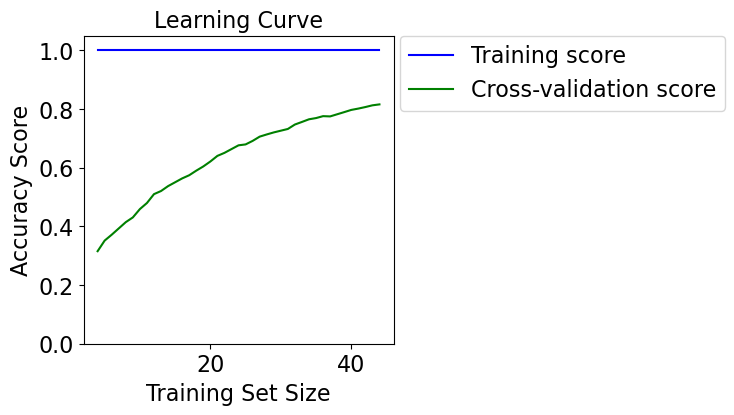

In [24]:
rcParams['figure.figsize'] = 4, 4     
# dotted blue line is for training scores and green line is for cross-validation score
plt.plot(sizes, train_score/100, color="b",  label="Training score")
plt.plot(sizes, test_score/100, color="g", label="Cross-validation score")
plt.ylim(0.0, 1.05)
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,)
plt.tight_layout()
plt.savefig('InN_M_learning_curve.pdf',dpi = 300)

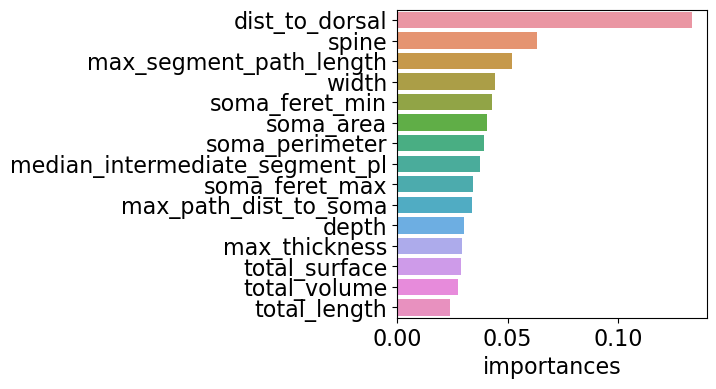

In [15]:
importances = importances.sort_values(by=['importances'],ascending=False)
rcParams['figure.figsize'] = 4, 4
sns.barplot(x= importances['importances'].iloc[0:15]/100, y = list(importances.index)[0:15])
plt.savefig('InN_M_importances.pdf',dpi = 300)

In [16]:
selected_var = importances.iloc[0:15]
var_name = list(selected_var.index)
adata = data[var_name].values
scaled_adata = StandardScaler().fit_transform(adata)
reducer = umap.UMAP(random_state =1,min_dist = 0.8,n_neighbors=15)
scaled_adata = pd.DataFrame(scaled_adata,columns= var_name)
for par in var_name:
    scaled_adata[par] = scaled_adata[par]*importances.loc[par]['importances']
scaled_adata = scaled_adata.values
embedding = reducer.fit_transform(scaled_adata)

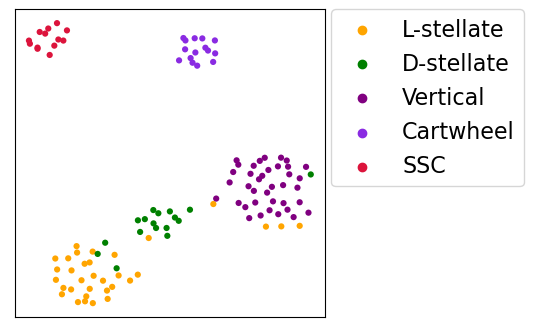

In [17]:
rcParams['figure.figsize'] = 4, 4
palette = {'Cartwheel':'blueviolet', 
           'D-stellate': 'green',
           'L-stellate': 'orange',
           'SSC': 'crimson',
           'Vertical': 'purple'
          }
sns.scatterplot(x=embedding[:, 0], y= embedding[:, 1],
                hue = y, s = 20,
                palette = palette,
                edgecolor="none",)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,)
plt.xticks([])
plt.yticks([])
plt.savefig('InN_M_cluster_true_label.pdf',dpi = 300)

([], [])

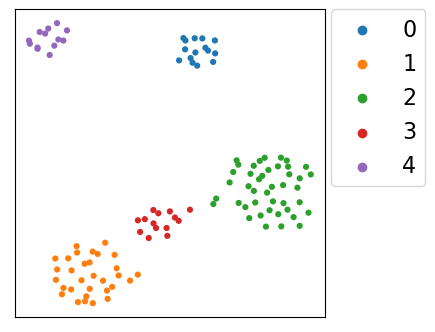

In [18]:
kmeans_labels = cluster.MiniBatchKMeans(n_clusters=5,random_state=0).fit_predict(scaled_adata)
rcParams['figure.figsize'] = 4, 4
# palette = {'Bushy': 'deepskyblue', 
#            'Octopus': 'violet',
#            'Fusiform': 'brown',
#            'T-stellate': 'coral'
#           }
palette = 'tab10'
sns.scatterplot(x=embedding[:, 0], y= embedding[:, 1],
                hue = kmeans_labels, s = 20,
                palette = palette,
                edgecolor="none",)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,)
plt.xticks([])
plt.yticks([])

Cartwheel 15 / 15 100.00%
D-stellate 13 / 14 92.86%
L-stellate 28 / 31 90.32%
SSC 13 / 13 100.00%
Vertical 38 / 43 88.37%
92.24%


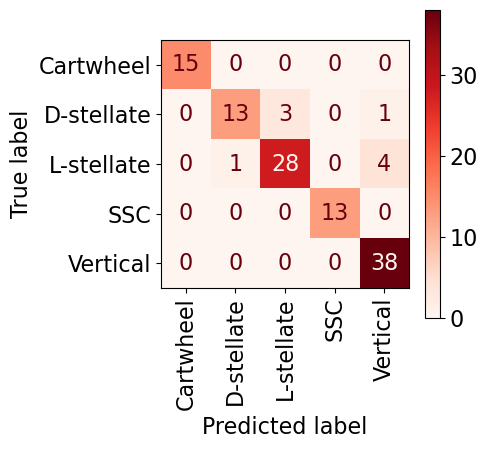

In [19]:
pred_labs = kmeans_labels.astype('object')
x_true = data.Expert_label
df = pd.DataFrame()
df['Expert_label'] =  x_true
df['pred'] = kmeans_labels
for i in range(0,kmeans_labels.max()+1,1):
    pred_labs[pred_labs == i] = df[df['pred'] == i].groupby(by = ['Expert_label']).count()['pred'].idxmax()

y_pred = pred_labs
cm = confusion_matrix(x_true, y_pred,#normalize = 'pred'
                     )

ax = ConfusionMatrixDisplay(cm, display_labels=labels)
ax.plot(cmap = 'Reds',xticks_rotation='vertical', include_values =True)

true_n = 0
total_n = 0
for i in range(0,5,1):
    print(labels[i],cm[i,i],'/',sum(cm[:,i]), str('%.2f'%(cm[i,i]/sum(cm[:,i])*100.0))+'%')
    true_n = true_n + cm[i,i]
    total_n = total_n + sum(cm[:,i])   

    acur_rate = true_n/total_n*100.0

print(str('%.2f'%(acur_rate))+'%')

Text(0, 0.5, 'Expert Label')

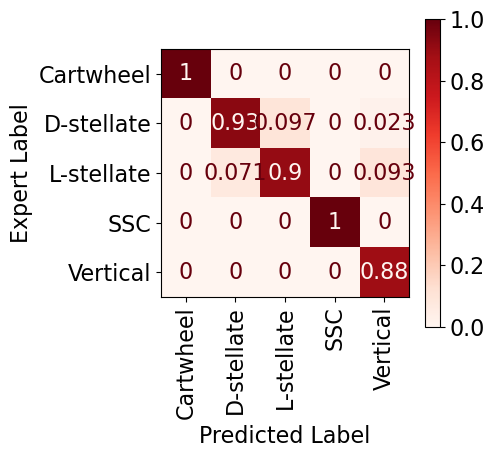

In [20]:
cm = cm.astype(np.float32)
for i in range(0,5,1):
    cm[:,i] = cm[:,i]/sum(cm[:,i])
x_true = data.Expert_label
y_pred = pred_labs
cm = confusion_matrix(x_true, y_pred,
                    normalize = 'pred'
                     )
labels  = sorted(labels)
ax = ConfusionMatrixDisplay(cm, display_labels=labels)
ax.plot(cmap = 'Reds',xticks_rotation='vertical', include_values =True)
#plt.grid(True)
plt.rc('axes', titlesize=16)     
plt.rc('axes', labelsize=16)
plt.rc('font', size=16) 
plt.rc('figure', titlesize=16)
plt.rc('legend', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('Expert Label')


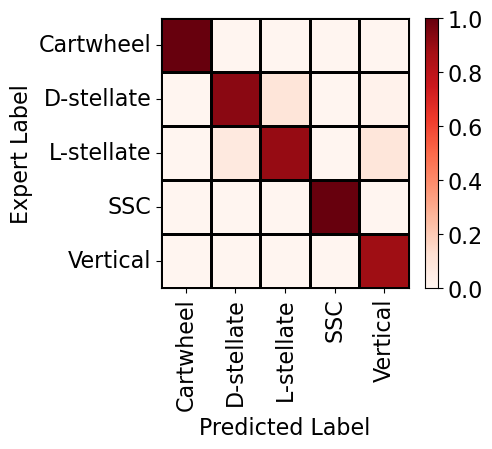

In [21]:
cm = cm.astype(np.float32)
for i in range(0,4,1):
    cm[:,i] = cm[:,i]/sum(cm[:,i])
rcParams['figure.figsize'] = 4, 3.5
ax = sns.heatmap(cm, cmap='Reds',cbar=True,
                 linewidths=1, linecolor='black'#,annot = True, annot_kws = {'size':14},fmt='0.3f'
                )
sns.despine(top = False, right = False, left = False,bottom = False)  
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_yticklabels(ax.get_yticklabels(),rotation = 0)

plt.rc('axes', titlesize=16)     
plt.rc('axes', labelsize=16)
plt.rc('font', size=16) 
plt.rc('figure', titlesize=16)
plt.rc('legend', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('Expert Label')
plt.savefig('InN_M_cluster_Matrix.pdf',dpi = 300)

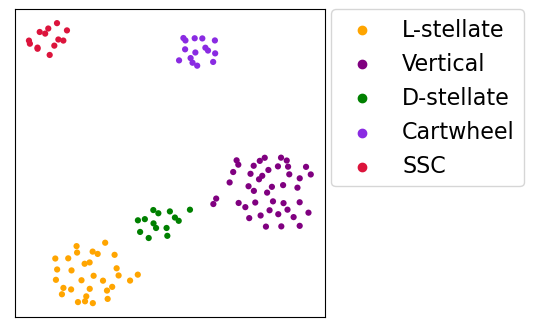

In [22]:
rcParams['figure.figsize'] = 4, 4
palette = {'Cartwheel':'blueviolet', 
           'D-stellate': 'green',
           'L-stellate': 'orange',
           'SSC': 'crimson',
           'Vertical': 'purple'
          }
sns.scatterplot(x=embedding[:, 0], y= embedding[:, 1],
                hue = pred_labs, s = 20,
                palette = palette,
                edgecolor="none",)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,)
plt.xticks([])
plt.yticks([])
plt.savefig('InN_M_cluster_pred_label.pdf',dpi = 300)

In [23]:
data['Mor_umapX'] = embedding[:, 0]
data['Mor_umapY'] = embedding[:, 1]
data['Mor_Pred'] = pred_labs

([], [])

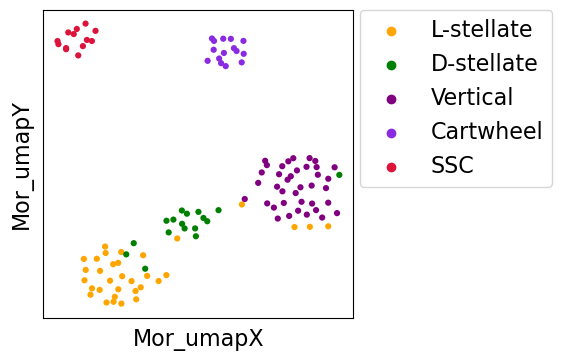

In [24]:
rcParams['figure.figsize'] = 4, 4
sns.scatterplot(x=data['Mor_umapX'], y= data['Mor_umapY'],
                hue = data['Expert_label'], s = 20,
                palette = palette,
                edgecolor="none",)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,)
plt.xticks([])
plt.yticks([])

In [25]:
data.to_csv('InN_Mor_classifier.csv',index = False)

In [26]:
data = pd.read_csv('Morpholoy_data.csv')
data =data[data['Expert_label'].isin(['L-stellate','D-stellate','Cartwheel','Vertical','SSC'])]
selected_var = importances.iloc[0:15]
var_name = list(selected_var.index)
adata = data[var_name].values
scaled_adata = StandardScaler().fit_transform(adata)
reducer = umap.UMAP(random_state =1,min_dist = 0.5,n_neighbors=15)
scaled_adata = pd.DataFrame(scaled_adata,columns= var_name)
for par in var_name:
    scaled_adata[par] = scaled_adata[par]*importances.loc[par]['importances']
scaled_adata = scaled_adata.values
embedding = reducer.fit_transform(scaled_adata)
data['MumapX']=embedding[:, 0]
data['MumapY']=embedding[:, 1]

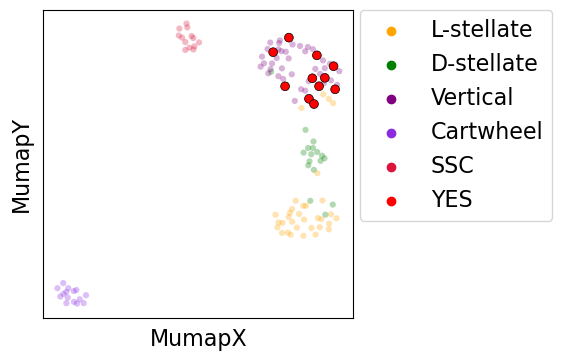

In [27]:
rcParams['figure.figsize'] = 4, 4
palette = {'Cartwheel':'blueviolet', 
           'D-stellate': 'green',
           'L-stellate': 'orange',
           'SSC': 'crimson',
           'Vertical': 'purple'
          }
sns.scatterplot(x = data['MumapX'], y= data['MumapY'],
                hue = data['Expert_label'], s = 20,
                palette = palette,
                edgecolor="none",alpha = 0.3)

sns.scatterplot(x=data[data['Penk_tdTomato'].isin(['YES'])]['MumapX'], 
                y= data[data['Penk_tdTomato'].isin(['YES'])]['MumapY'],
                hue = data[data['Penk_tdTomato'].isin(['YES'])]['Penk_tdTomato'], s = 40,
                palette = {'YES':'Red'},
                edgecolor="Black",alpha = 1)


plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,)
plt.xticks([])
plt.yticks([])
plt.savefig('InN_M_cluster_Penk.pdf',dpi = 300)
plt.savefig('InN_M_cluster_Penk.png',dpi = 300)